<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_PyTorch/blob/main/31AttentionPoolingBySimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

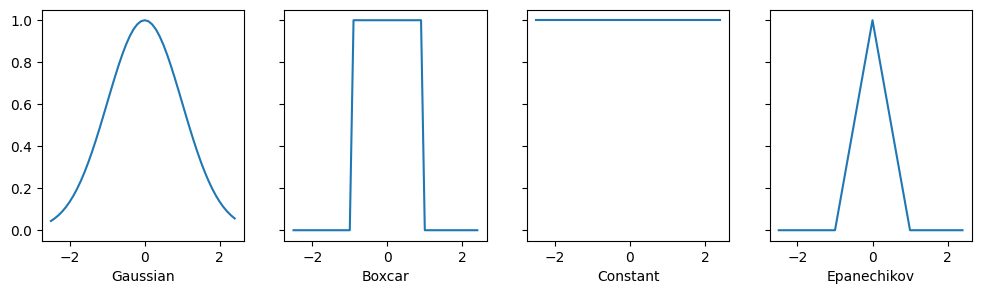

In [2]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

plt.show()

The torch.sort function in PyTorch returns a tuple containing two tensors: the sorted tensor and the indices of the original tensor in the sorted order. By default, it sorts in ascending order along the last dimension. You can specify a different dimension and sorting order (ascending or descending).

Here's an example:

Let's say you have a tensor x:

x = torch.tensor([5, 2, 8, 1])
When you apply torch.sort(x):

The sorted tensor would be torch.tensor([1, 2, 5, 8]).
The indices tensor (showing where the sorted values came from in the original x) would be torch.tensor([3, 1, 0, 2]).
So, torch.sort(x) would return (torch.tensor([1, 2, 5, 8]), torch.tensor([3, 1, 0, 2])).

In [3]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
print(x_train)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

tensor([0.1240, 0.1598, 0.5889, 0.6160, 0.7767, 0.8086, 0.8381, 0.8601, 0.8979,
        0.9083, 0.9496, 1.2223, 1.5523, 1.6440, 1.8427, 1.8907, 2.0891, 2.1787,
        2.2130, 2.3003, 2.3254, 2.3559, 2.4008, 2.5333, 2.7433, 2.8105, 3.0510,
        3.4294, 3.4333, 3.6146, 3.7289, 3.7309, 3.8590, 3.8702, 3.9192, 4.5172,
        4.6828, 4.8270, 4.8769, 4.9361])


Certainly! Let's break down x_train.reshape((-1, 1)) and x_val.reshape((1, -1)).

x_train.reshape((-1, 1))
Original x_train: Imagine x_train is a 1-dimensional tensor (a simple list of numbers), for example: torch.tensor([10, 20, 30]).
reshape((-1, 1)): This tells PyTorch to reshape the tensor into a 2-dimensional tensor with 1 column. The -1 is a wildcard that means "figure out the number of rows automatically based on the total number of elements".
Result: The tensor torch.tensor([10, 20, 30]) would become a column vector like this:
[[10],
 [20],
 [30]]
It's now a 3x1 tensor.
x_val.reshape((1, -1))
Original x_val: Similarly, imagine x_val is also a 1-dimensional tensor, for example: torch.tensor([1, 2, 3, 4]).
reshape((1, -1)): This tells PyTorch to reshape the tensor into a 2-dimensional tensor with 1 row. Again, the -1 means "figure out the number of columns automatically".
Result: The tensor torch.tensor([1, 2, 3, 4]) would become a row vector like this:
[[1, 2, 3, 4]]
It's now a 1x4 tensor.
Why these reshapes and the subtraction dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))?
When you subtract these two reshaped tensors, PyTorch uses a mechanism called broadcasting. It effectively expands the smaller tensor's dimensions to match the larger one so that the operation can be performed element-wise.

In our example:

x_train_reshaped is [[10], [20], [30]] (3x1)
x_val_reshaped is [[1, 2, 3, 4]] (1x4)
When you subtract them:

The x_train_reshaped (3x1) is conceptually stretched across 4 columns.
The x_val_reshaped (1x4) is conceptually stretched across 3 rows.
The result dists will be a 3x4 tensor where each element dists[i, j] is x_train[i] - x_val[j]:

[[10-1, 10-2, 10-3, 10-4],
 [20-1, 20-2, 20-3, 20-4],
 [30-1, 30-2, 30-3, 30-4]]

=

[[ 9,  8,  7,  6],
 [19, 18, 17, 16],
 [29, 28, 27, 26]]
This is a common pattern in machine learning to compute element-wise differences (or distances) between every element of one set of data points (x_train) and every element of another set (x_val).

In [4]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

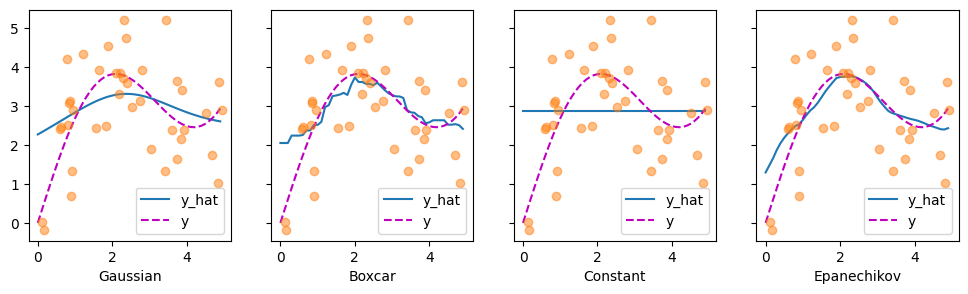

In [5]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

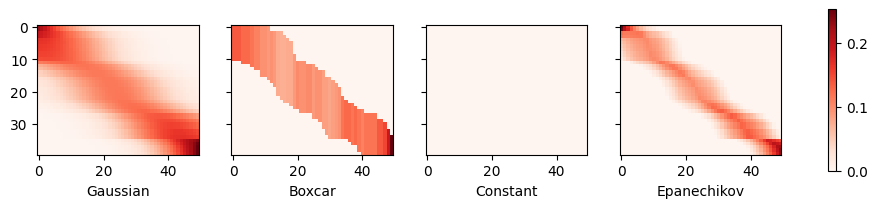

In [6]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

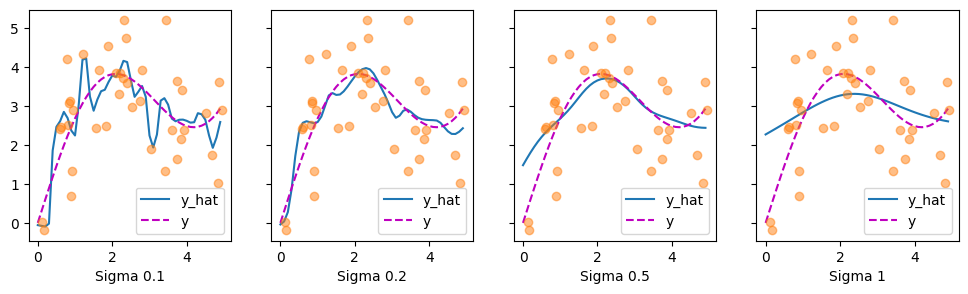

In [7]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

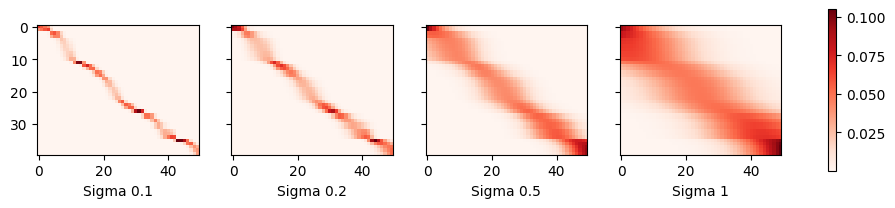

In [8]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)